#Pulser
Today we explore the Pulser package for simulating quantum algorithms on a neutral atom QPU.

### References
Pulser documentation: https://pulser.readthedocs.io/en/stable/

Pulser white paper: https://arxiv.org/abs/2104.15044

Live simulation of QPU: https://www.pasqal.com/solutions/pulser-studio

<b>puccj</b> This ^ was been shown during lesson

Paper on CZ gate: [1111.6083v2](https://arxiv.org/abs/1111.6083)

# Control-Z Gate Sequence

## Introduction

In this tutorial we show how to prepare the pulse sequence that generates a *Controlled - Z* gate. We will prepare our state with atoms in any of the "digital" states that we shall call $|g\rangle$ and $|h \rangle$ ( for "ground" and "hyperfine", respectively). Then we will use the *Rydberg blockade* effect to create the logic gate. The levels that each atom can take are the following:
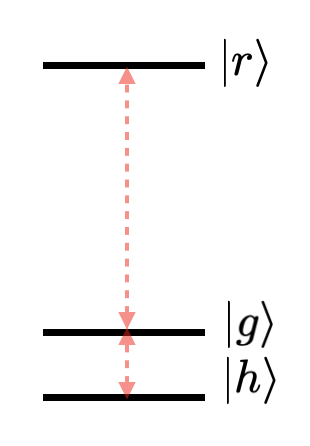
<center><img src="attachment:three_states.png" width="120"/></center>

We will be using *NumPy* and *Matplotlib* for calculations and plots. Many additional details about the CZ gate construction can be found in [1111.6083v2](https://arxiv.org/abs/1111.6083)

##0. Imports

We need to import a few packages. Firstly qutip, a python package for simulating quantum systems (https://qutip.org/).

Tip: when using a notebook you can always write in bash by adding ! in front of your command.

In [4]:
!pip install qutip

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.3/16.3 MB 102.7 MB/s eta 0:00:00


And now we import Pulser, the PASQAL's python package to simulate the Rydberg QPU.

In [5]:
!pip install pulser

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.2/169.2 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.6/122.6 kB 16.5 MB/s eta 0:00:00
  Attempting uninstall: pyjwt
    Found existing installation: PyJWT 2.3.0
    Uninstalling PyJWT-2.3.0:
      Successfully uninstalled PyJWT-2.3.0


Now we can proceed to import the packages:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import qutip
from itertools import product

We import the following Classes from Pulser:

In [2]:
from pulser import Pulse, Sequence, Register
from pulser.devices import Chadoq2
from pulser_simulation import QutipEmulator
from pulser.waveforms import BlackmanWaveform, ConstantWaveform

## 1. Loading the Register on a Device

The starting point in Pulser is the `Register` class which holds the information about the atoms: their positions, distances, ids and so on.
One way to create an atom register can simply be done by choosing one of the predetermined shapes included in the `Register` class.
Let us try 2 of them: Square and triangular lattice.



SquareLatticeLayout(7x4, 5.0µm)


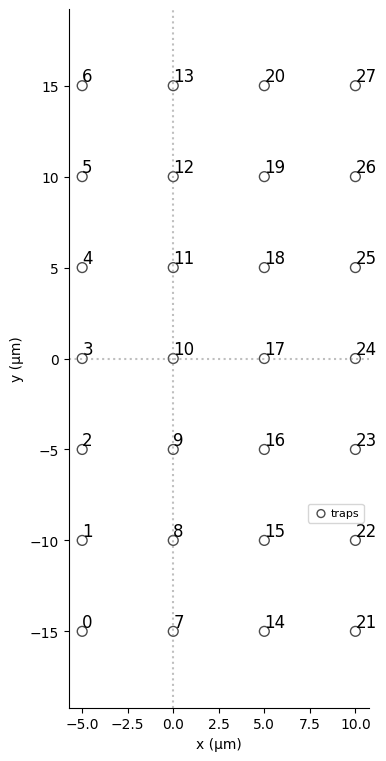

In [3]:
from pulser.register.special_layouts import (
    SquareLatticeLayout,
    TriangularLatticeLayout,
)

### A Layout is a set of optical traps and each one can capture at most one atom
square_layout = SquareLatticeLayout(7, 4, spacing=5)
print(square_layout)
square_layout.draw()

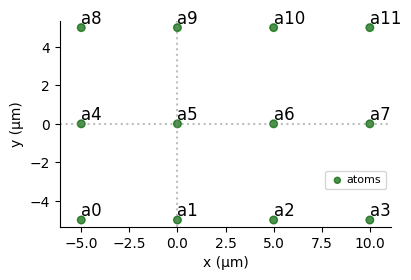

In [4]:
### With the layout object we can create a register with a predefined number of columns
square_layout.rectangular_register(rows=3, columns=4, prefix="a").draw()

Again, but with a triangular lattice now:

TriangularLatticeLayout(100, 5.0µm)


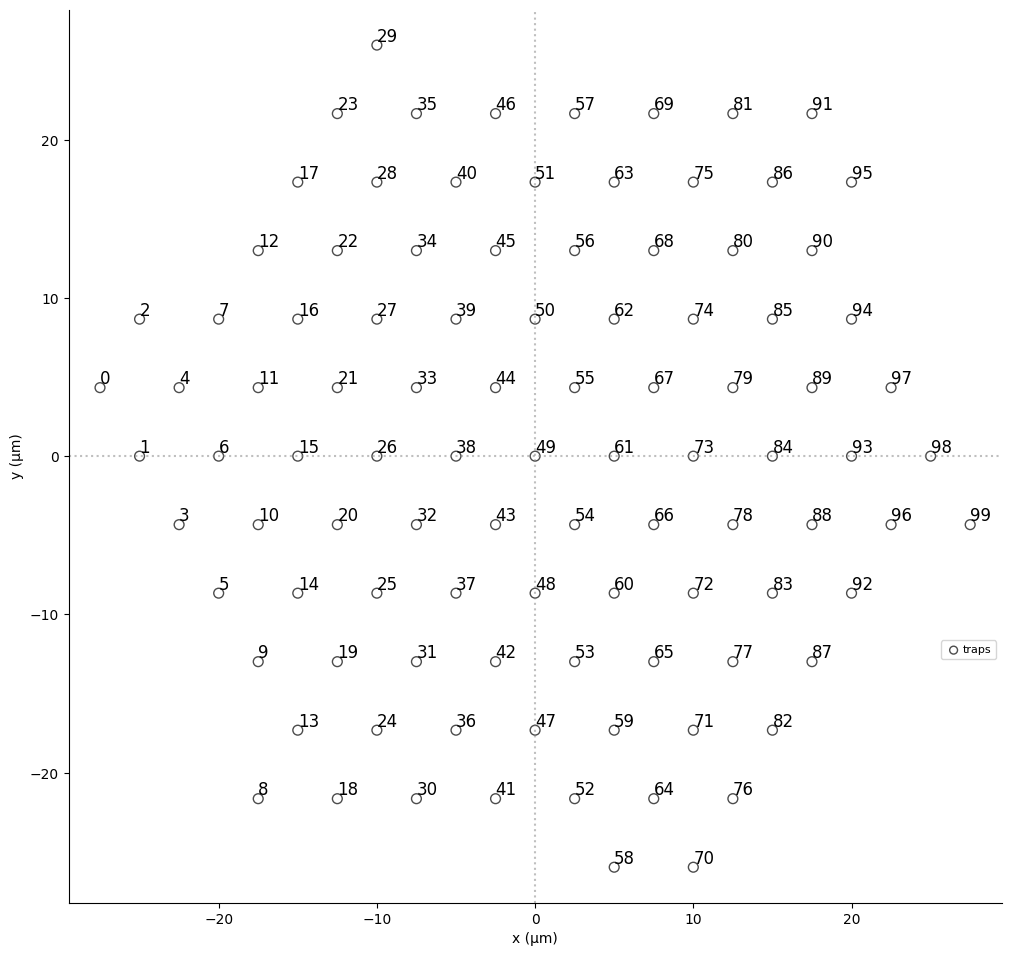

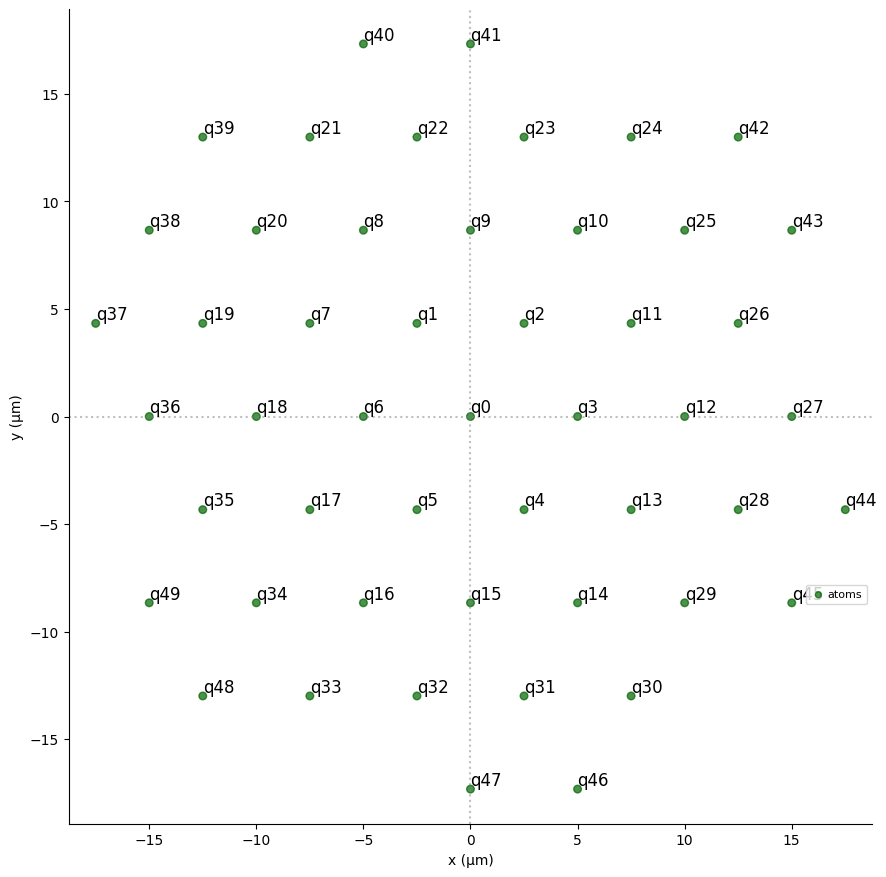

In [5]:
tri_layout = TriangularLatticeLayout(n_traps=100, spacing=5)
print(tri_layout)
tri_layout.draw()
tri_layout.hexagonal_register(n_atoms=50).draw()


Another way to create a register is to construct a dictionary which contains the position and an id for each atom. Since we want our qubits to interact, the atoms must lie inside the *Rydberg blockade radius* $R_b$, which we will characterize by

$$\hbar \Omega^{\text{Max}}_{\text{Rabi}} \sim U_{ij} = \frac{C_6}{R_{b}^6},$$

where the coefficient $C_6$ determines the strength of the interaction ($C_6/\hbar \approx 5008$ GHz.$\mu m^6$).

We can obtain the corresponding Rydberg blockade radius from a given $\Omega_{\text{Rabi}}^{\text{max}}$ using the `rydberg_blockade_radius()` method from `Chadoq2` which is one of the possible classes that emulate the QPU. For the pulses in this tutorial, $\Omega^{\text{Max}}_{\text{Rabi}}$ is below $2\pi \times 10$ Mhz so:

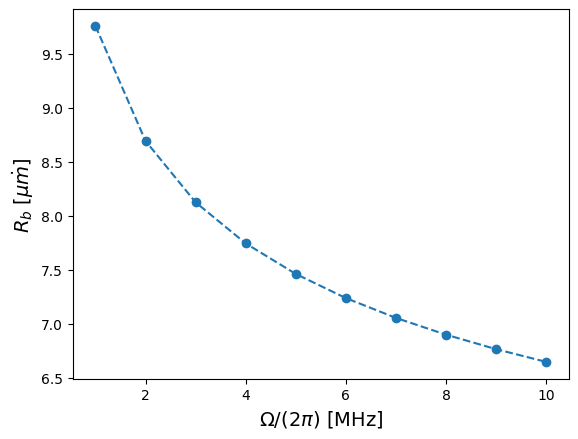

In [6]:
Rabi = np.linspace(1, 10, 10)
R_blockade = [
    Chadoq2.rydberg_blockade_radius(2.0 * np.pi * rabi) for rabi in Rabi
]

plt.figure()
plt.plot(Rabi, R_blockade, "--o")
plt.xlabel(r"$\Omega/(2\pi)$ [MHz]", fontsize=14)
plt.ylabel(r"$R_b$ [$\mu\.m$]", fontsize=14)
plt.show()

Thus, we place our atoms at relative distances below $5$ µm, therefore ensuring we are inside the Rydberg blockade volume.

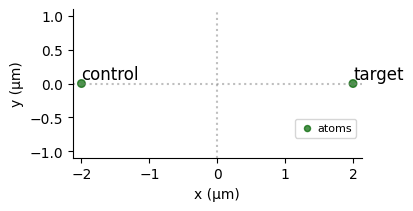

In [7]:
# Atom Register and Device
q_dict = {
    "control": np.array([-2, 0.0]),
    "target": np.array([2, 0.0]),
}
reg = Register(q_dict)
reg.draw()

## 2. State Preparation

As seen in the introduction we have three possible states for a qubit:
- $|g\rangle$ the ground state
- $|h\rangle$ the excited state (h for hyper-fine)
- $|r\rangle$ the Rydberg state

for this reason we have three types of basis:
- `digital`: $\{|g\rangle, |h\rangle\}$
- `ground-rydberg`: $\{|g\rangle, |r\rangle\} $
- `all`: $\{|g\rangle, |h\rangle, |r\rangle\} $

and two types of channels:
- Raman: acts on the `digital` basis
- Rabi: acts on the `ground-rydberg` basis
(both can be local: acting on a single qubit, or global)

We want to show the action of CZ on all four possible state of two qubits, that is the `digital` basis. For this reason the first part of our sequence of pulses (which performs the computation) will correspond to preparing the following states`gg`, `gh`, `hg`, `hh`.

Let us construct a function that takes the label string (or "id") of a state and turns it into a ket state. We also include a three-atom system case, which will be useful in the CCZ gate in the last section.

In [8]:
def build_state_from_id(s_id, basis_name):

    #Check the number of qubits (2 for CZ or 3 for CCZ)
    if len(s_id) not in {2, 3}:
        raise ValueError("Not a valid state ID string")

    #Check you picked an existing basis
    ids = {"digital": "gh", "ground-rydberg": "rg", "all": "rgh"}
    if basis_name not in ids:
        raise ValueError("Not a valid basis")

    #Check you start with a sensible set of states
    pool = {"".join(x) for x in product(ids[basis_name], repeat=len(s_id))}
    if s_id not in pool:
        raise ValueError("Not a valid state id for the given basis.")

    #Creates the initial quantum state with qutip
    ket = {
        op: qutip.basis(len(ids[basis_name]), i) #A basis object in qutip is nothing more than a vector with two entries (in this case)
        for i, op in enumerate(ids[basis_name])
    }
    if len(s_id) == 3:
        # Recall that s_id = 'C1'+'C2'+'T' while in the register reg_id = 'C1'+'T'+'C2'.
        #This is a reordering that is not very relevant at the moment
        reg_id = s_id[0] + s_id[2] + s_id[1]
        return qutip.tensor([ket[x] for x in reg_id])
    else:
        return qutip.tensor([ket[x] for x in s_id])

We try this out:

In [9]:
build_state_from_id("gg", "digital")

Quantum object: dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket
Qobj data =
[[1.]
 [0.]
 [0.]
 [0.]]

Let's now write the state preparation sequence of pulses. First, let us define a π-pulse along the Y axis that will excite the atoms to the hyperfine state if requested. Pulser has a whole class for shaping the pulses and they can be created in a pretty intuitive way. Here we will use the standard BlackmanWaveform pulse with a constant detuning. The most simple pulse is a constant pulse like the following:


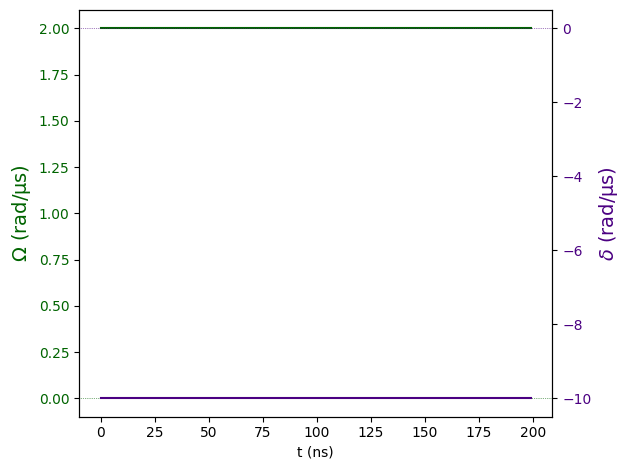

In [10]:
from pulser import Pulse
simple_pulse = Pulse.ConstantPulse(duration = 200, amplitude = 2, detuning = -10, phase = 0)
simple_pulse.draw()

We can also create customized pulses or standard ones, for our

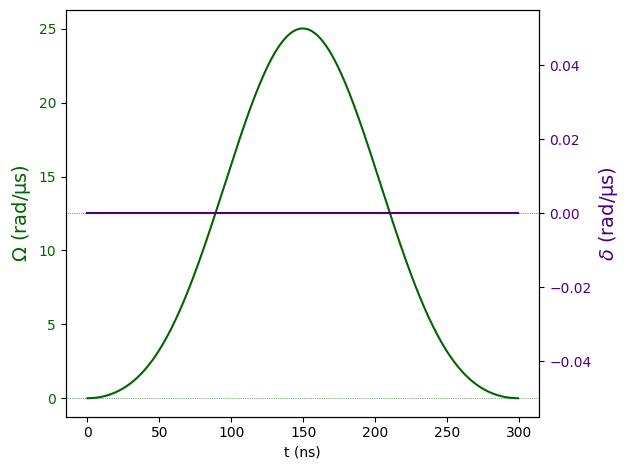

In [11]:
duration = 300
pi_Y = Pulse.ConstantDetuning(
    BlackmanWaveform(duration, np.pi), 0.0, -np.pi / 2
)
pi_Y.draw()

This is needed because all qubits start always in $|g\rangle$, thus if we want to simulate CZ on, e.g. the state $|hh\rangle$ our preparation scheme will apply the pY rotation to first and the second qubit.
To put together a serious of pulses Pulser offers a `Sequence` class. In the next lines of codes we will see how:

In [12]:
def preparation_sequence(state_id, reg):
    #notice the sequence object will be a global variable
    global seq

    #Check id exists
    if not set(state_id) <= {"g", "h"} or len(state_id) != len(reg.qubits):
        raise ValueError("Not a valid state ID")

    #Check if you want to apply CZ or CCZ (three qubits)
    if len(reg.qubits) == 2:
        seq_dict = {"1": "target", "0": "control"}
    elif len(reg.qubits) == 3:
        seq_dict = {"2": "target", "1": "control2", "0": "control1"}

    #Creation of a Sequence instance, the classe only needs the register and the
    #simulator
    seq = Sequence(reg, Chadoq2)

    if set(state_id) == {"g"}:
        basis = "ground-rydberg"
        print(
            f"Warning: {state_id} state does not require a preparation sequence."
        )
    else:
        basis = "all"
        for k in range(len(reg.qubits)):

            #Now a sequence objects needs a channel (remeber raman or rydberg)
            #to know which type of pulse to send. If it is not already explicited we can
            #do so by declaring a channel
            if state_id[k] == "h":
                if "raman" not in seq.declared_channels:
                    seq.declare_channel(
                        "raman", "raman_local", seq_dict[str(k)]
                    )
                else:
                    seq.target(seq_dict[str(k)], "raman")

                #Here is where we act with the pi_Y pulse
                seq.add(pi_Y, "raman")

    prep_state = build_state_from_id(
        state_id, basis
    )  # Raises error if not a valid `state_id` for the register

    return prep_state

Let's test this sequence. Notice that the state "gg" (both atoms in the ground state) is automatically fed to the Register so a pulse sequence is not needed to prepare it. Choose one element of the digital basis and see how many pulses are needed to prepare it:

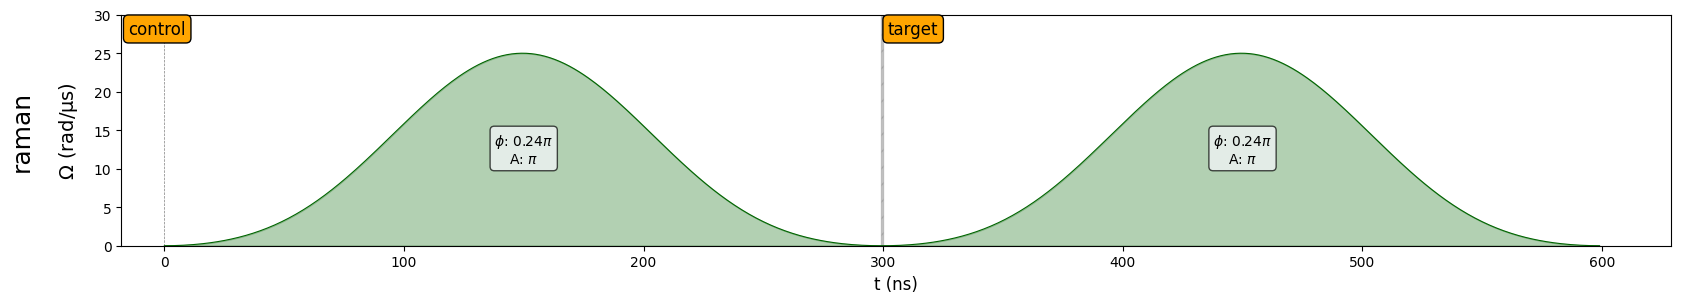

In [13]:
# Define sequence and Set channels
prep_state = preparation_sequence("hh", reg)
seq.draw(draw_phase_area=True)

## 3. Constructing the Gate Sequence

We apply the common $\pi-2\pi-\pi$ sequence for the CZ gate.

First, let us define the two $\pi$ and $2\pi$ pulses:

In [14]:
pi_pulse = Pulse.ConstantDetuning(BlackmanWaveform(duration, np.pi), 0.0, 0)
twopi_pulse = Pulse.ConstantDetuning(
    BlackmanWaveform(duration, 2 * np.pi), 0.0, 0
)

And now a function that accepts the wanted initial configuration and returns a sequence object which combines the initial state-preparation sequence with the CZ sequence.

In [15]:
def CZ_sequence(initial_id):
    # Prepare State
    prep_state = preparation_sequence(initial_id, reg)
    prep_time = max(
        (seq._last(ch).tf for ch in seq.declared_channels), default=0
    )

    # Declare Rydberg channel
    seq.declare_channel("ryd", "rydberg_local", "control")

    # Write CZ sequence:
    seq.add(
        pi_pulse, "ryd", "wait-for-all"
    )  # Wait for state preparation to finish.
    seq.target("target", "ryd")  # Changes to target qubit
    seq.add(twopi_pulse, "ryd")
    seq.target("control", "ryd")  # Changes back to control qubit
    seq.add(pi_pulse, "ryd")

    return prep_state, prep_time

And we draw it here:

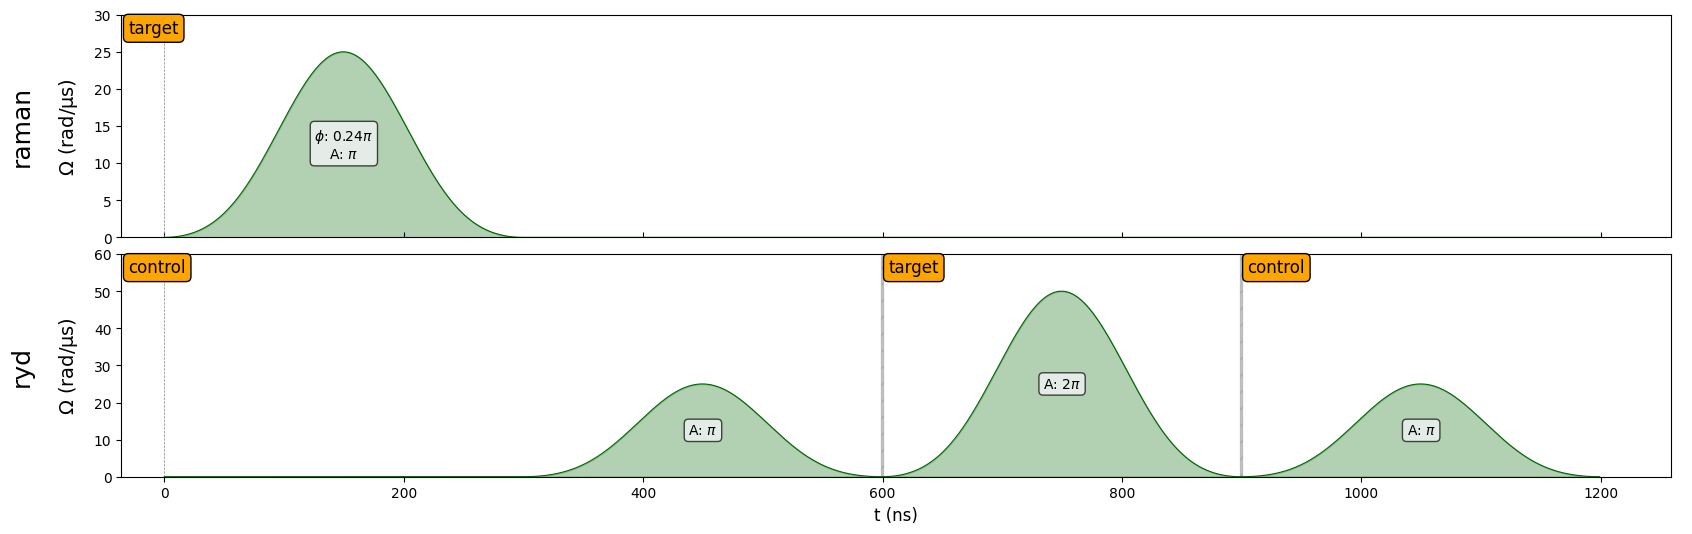

Prepared state: Quantum object: dims = [[3, 3], [1, 1]], shape = (9, 1), type = ket
Qobj data =
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]]
Preparation time: 300ns


In [16]:
prep_state, prep_time = CZ_sequence(
    "gh"
)  # constructs seq, prep_state and prep_time
seq.draw(draw_phase_area=True)
print(f"Prepared state: {prep_state}")
print(f"Preparation time: {prep_time}ns")

## 4. Simulating the CZ sequence

It is time to test our sequence. We will see its action on each possible basis state and in order to be more aware of what happens during this computation we will calculate the overlapping between the current state and the initial state at different time steps.

In order to run a sequence we need a simulator object, the standard is QutipEmulator, that will approximate the evolution of the system under the pulses and only need to know the sequence we created. Once we run it we obtain a results object with all the information of the computation. In particular we can get the quantum state $|\Psi\rangle$ at every step of the evolution. This is what we use to calculate the overlaps between the basis elements and $|\Psi\rangle$.

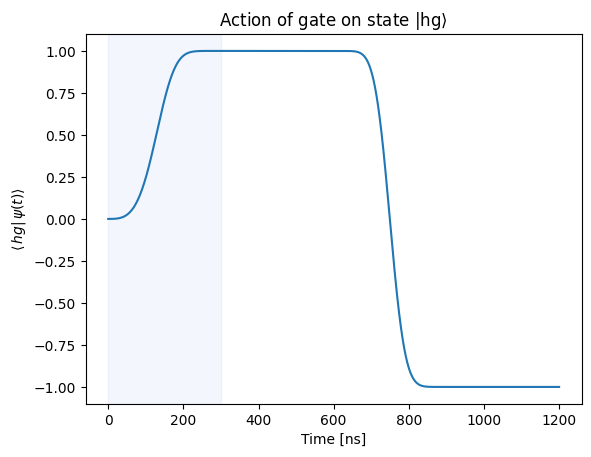

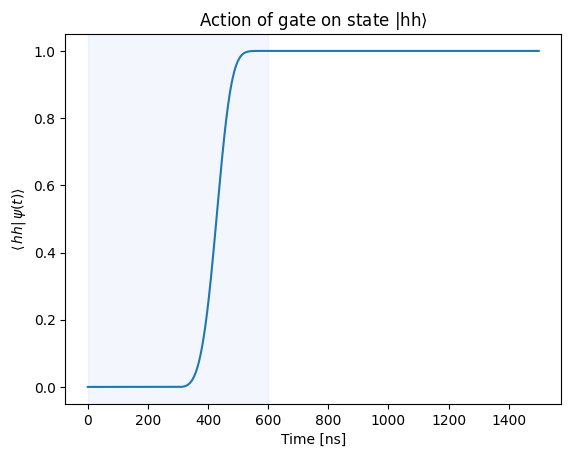

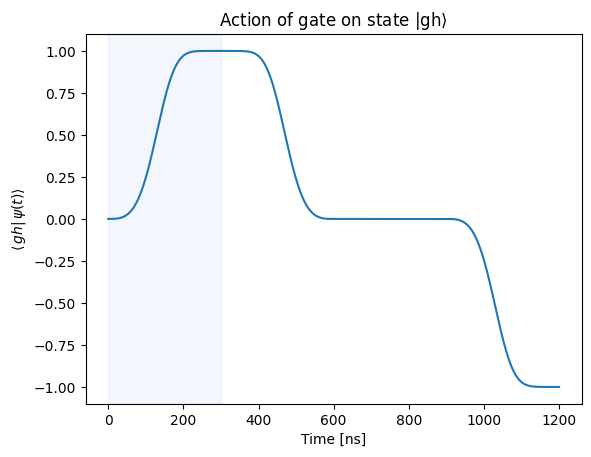

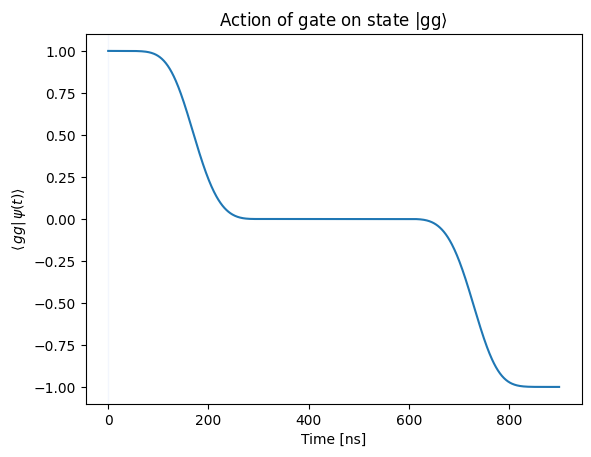

In [17]:
#puccj: Now we do the simulation for gg, hg, gh, hh  (= 00, 10, 01, 11)

CZ = {}
for state_id in {"gg", "hg", "gh", "hh"}:
    # Get CZ sequence
    prep_state, prep_time = CZ_sequence(
        state_id
    )  # constructs seq, prep_state and prep_time

    # Construct Simulation instance
    simul = QutipEmulator.from_sequence(seq)
    res = simul.run()

    data = [st.overlap(prep_state) for st in res.states]

    final_st = res.states[-1]
    CZ[state_id] = final_st.overlap(prep_state)

    plt.figure()
    plt.plot(np.real(data))
    plt.xlabel(r"Time [ns]")
    plt.ylabel(rf"$ \langle\,{state_id} |\, \psi(t)\rangle$")
    plt.axvspan(0, prep_time, alpha=0.06, color="royalblue")
    plt.title(rf"Action of gate on state $|${state_id}$\rangle$")

Putting it all together:

In [18]:
CZ

{'hg': (-0.9999999998467323+1.8369701984394796e-16j),
 'hh': (0.9999999998981344-3.673940397067816e-16j),
 'gh': (-0.999999999746591+1.8369701982555325e-16j),
 'gg': (-0.999072784367098+0.043053123744509016j)}

##  5. CCZ Gate

The same principle can be applied for composite gates. As an application, let us construct the *CCZ* gate, which determines the phase depending on the level of *two* control atoms. We begin by reconstructing the Register:

<b> puccj: </b> So these are 3 entangled particles

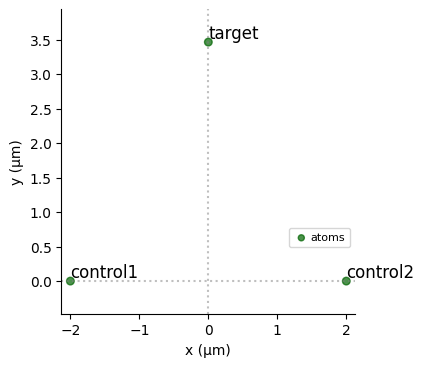

In [23]:
# Atom Register and Device
q_dict = {
    "control1": np.array([-2.0, 0.0]),
    "target": np.array([0.0, 2 * np.sqrt(3.001)]),
    "control2": np.array([2.0, 0.0]),
}
reg = Register(q_dict)
reg.draw()

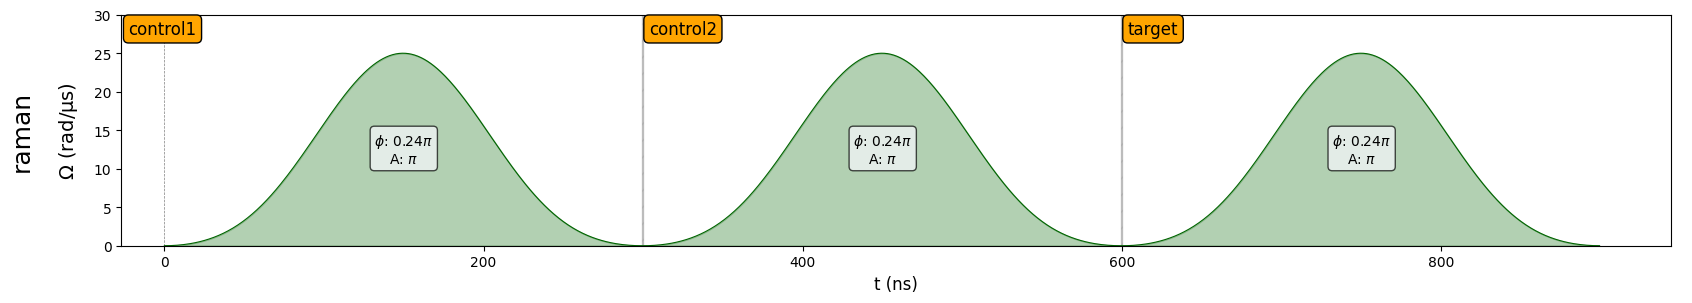

In [24]:
preparation_sequence("hhh", reg)
seq.draw(draw_phase_area=True)

In [25]:
def CCZ_sequence(initial_id):
    # Prepare State
    prep_state = preparation_sequence(initial_id, reg)
    prep_time = max(
        (seq._last(ch).tf for ch in seq.declared_channels), default=0
    )

    # Declare Rydberg channel
    seq.declare_channel("ryd", "rydberg_local", "control1")

    # Write CCZ sequence:
    seq.add(
        pi_pulse, "ryd", protocol="wait-for-all"
    )  # Wait for state preparation to finish.
    seq.target("control2", "ryd")
    seq.add(pi_pulse, "ryd")
    seq.target("target", "ryd")
    seq.add(twopi_pulse, "ryd")
    seq.target("control2", "ryd")
    seq.add(pi_pulse, "ryd")
    seq.target("control1", "ryd")
    seq.add(pi_pulse, "ryd")

    return prep_state, prep_time

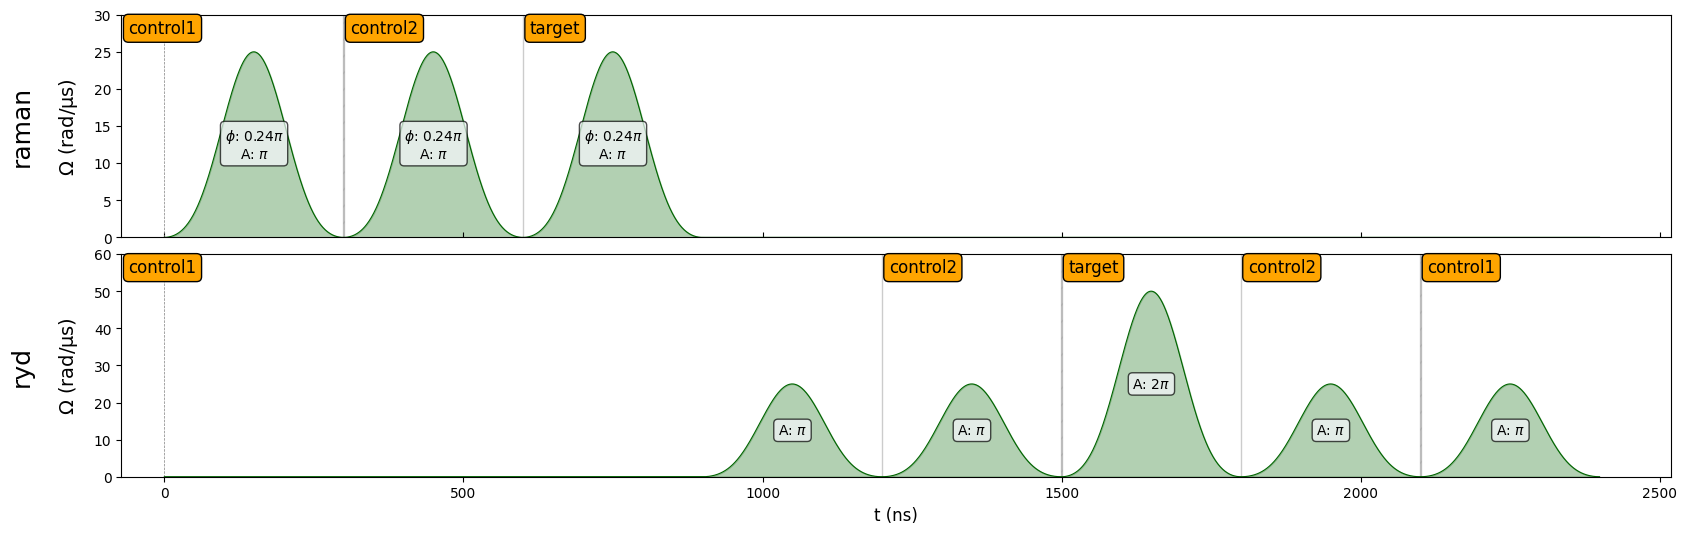

In [26]:
CCZ_sequence("hhh")
seq.draw(draw_phase_area=True)

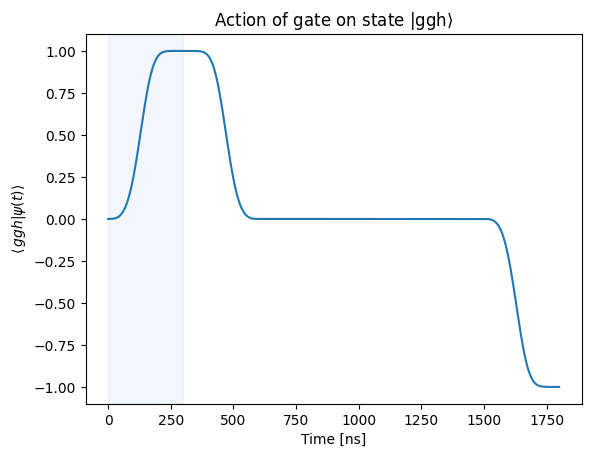

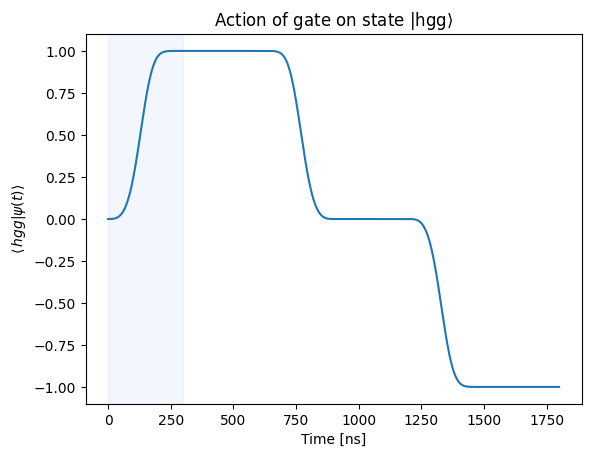

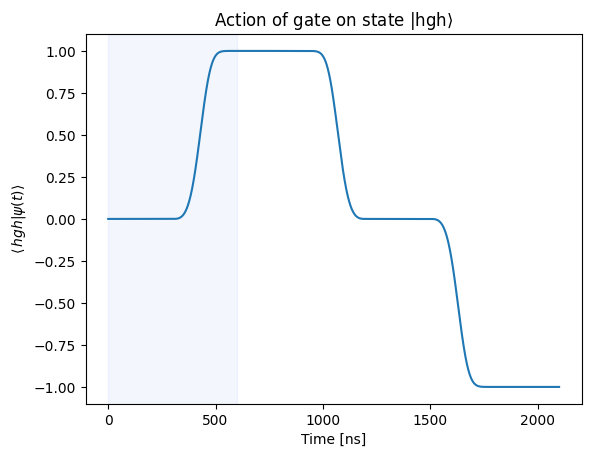

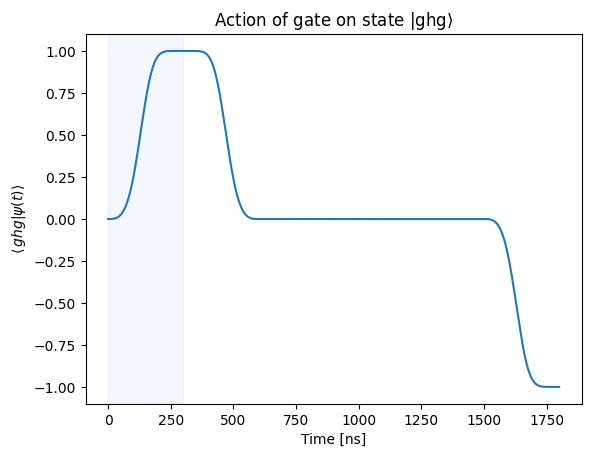

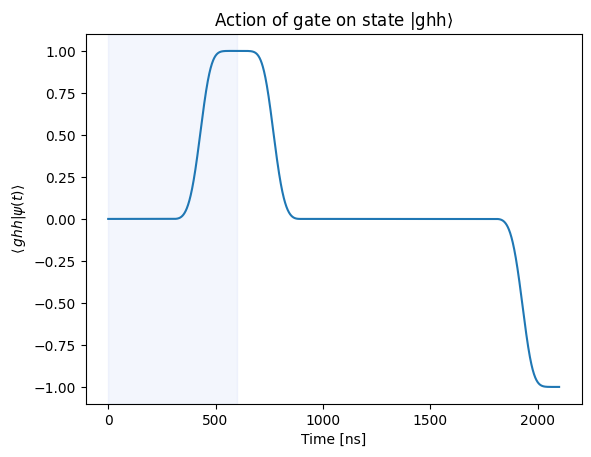

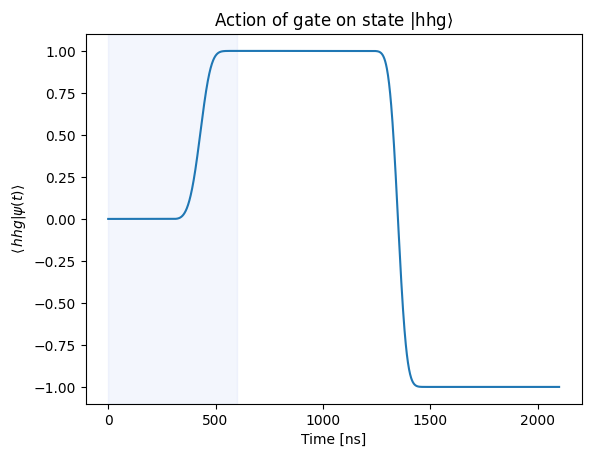

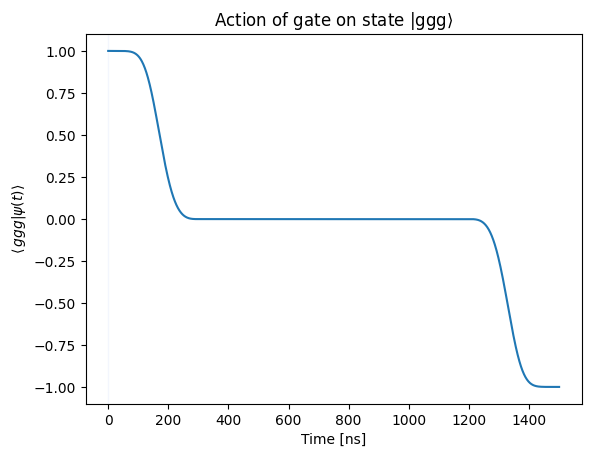

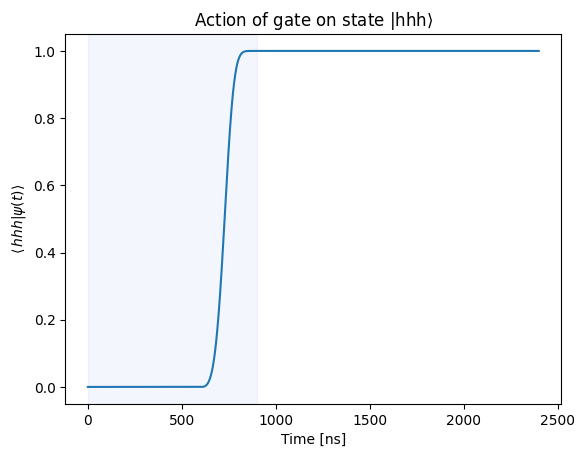

In [27]:
CCZ = {}
for state_id in {"".join(x) for x in product("gh", repeat=3)}:
    # Get CCZ sequence
    prep_state, prep_time = CCZ_sequence(state_id)

    # Construct Simulation instance
    simul = QutipEmulator.from_sequence(seq)

    res = simul.run()

    data = [st.overlap(prep_state) for st in res.states]
    final_st = res.states[-1]
    CCZ[state_id] = final_st.overlap(prep_state)

    plt.figure()
    plt.plot(np.real(data))
    plt.xlabel(r"Time [ns]")
    plt.ylabel(rf"$ \langle\,{state_id} | \psi(t)\rangle$")
    plt.axvspan(0, prep_time, alpha=0.06, color="royalblue")
    plt.title(rf"Action of gate on state $|${state_id}$\rangle$")

In [28]:
CCZ

{'ggh': (-0.9997680559526282+0.02153681158672384j),
 'hgg': (-0.9990713580955077+0.04308613130117794j),
 'hgh': (-0.9999999965725214+3.6739403848496783e-16j),
 'ghg': (-0.999071376576915+0.04308578034821871j),
 'ghh': (-0.99999999995561+3.6739403972789525e-16j),
 'hhg': (-0.999999999909926+3.673940397111129e-16j),
 'ggg': (-0.9979118035390383+0.06459125763827649j),
 'hhh': (0.9999999999559365-5.510910595920267e-16j)}

Our results are as expected: only the $|hhh\rangle$ state (which corresponds to a $111$ digital state) gets its phase flipped in sign